In [ ]:
!pip3 install mysql-connector-python
!pip3 install mysql-connector

In [2]:
#import mysql.connector as sql
import pandas as pd
import MySQLdb as sql

In [ ]:
t_db_connection = sql.connect(host='hostname', db='db_name', user='username', passwd='password')

#home iP: 74.66.6.133

t_cur1 = db_connection.cursor


In [ ]:
!pip3 install pyodbc
import pyodbc
import pandas as pd
  
# server name: EC2AMAZ-V1NLV3G
# db name: TickerData
# table name: dbo.TickerHistory
# conn = pyodbc.connect(r'Driver={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=C:\Users\Ron\Desktop\testdb.accdb;')

q_db_connection = pyodbc.connect('Driver={SQL Server};'
                      'Server=EC2AMAZ-V1NLV3G;'
                      'Database=dbo.TickerHistory;'
                      'Uid=sa;'
                      'Pwd=JST@123'
                      'Trusted_Connection=yes;')

q_cur1 = q_db_connection.cursor()
q_cur2 = q_db_connection.cursor()

In [ ]:
# THIS IS THE CELL FOR: mySQL QUERIES (trades_data)


query_select_orders_for_allCashTrades = t_cur1.execute('''SELECT creationTime, sendTime, orderQty, filledPrice, orderStatus,
                                  filledShares, side, lastUpdateTime, notes, session_id FROM riskmanager.child_orders
                                  WHERE notes LIKE '%FIX%' AND filledShares>0''')




'''select
product_name,
product_price_per_unit,
units_ordered,
((units_ordered) * (product_price_per_unit)) AS revenue
from tracking_sales'''


In [ ]:
# THIS IS THE CELL FOR: SQL Server QUERIES (quotes_data)


query_select_exchangeCurrencyId_for_USD = q_cur1.execute('''SELECT * from TickerData.dbo.ExchangeCurrency
WHERE SecondCurrencyId = 4''')


# query: select createdDate in the sendTime range for the cash trades; 
# or include only in the trades iteration? 
query_select_bbo_from_quotes = q_cur2.execute('''SELECT ExchangeCurrencyId, Ask, Bid, Volume, CreatedDate,
                                (Ask + Bid)/2 AS Mid
                                FROM TickerData.dbo.TickerHistory
                                WHERE CreatedDate BETWEEN (SELECT sendTime FROM riskmanager.child_orders 
                                WHERE notes LIKE '%FIX%' AND filledShares>0 ORDER BY sendTime ASC LIMIT 1) AND 
                                (SELECT sendTime FROM riskmanager.child_orders 
                                WHERE notes LIKE '%FIX%' AND filledShares>0 ORDER BY sendTime DESC LIMIT 1) AND 
                                ExchangeCurrencyId IN (??????? ExchangeCurrencyId_List?????)''')
   

In [ ]:
# THIS IS THE CELL FOR: DATAFRAMES


'''df_allCashTrades = pd.DataFrame(query_select_orders_for_allCashTrades, 
                         columns=['creationTime','sendTime','orderQty','filledPrice','orderStatus',
                                  'filledShares','side','lastUpdateTime','notes','session_id'])
'''
df_allCashTrades = pd.DataFrame(query_select_orders_for_allCashTrades.fetchall())
df_allCashTrades.columns = query_select_orders_for_allCashTrades.column_names
grouped = df_allCashTrades.groupby('notes')
#df_allCashTrades_BTC = grouped.get_group('FIX BTC/USD')
#df_allCashTrades_ETH = grouped.get_group('FIX ETH/USD')
#df_allCashTrades_XRP = grouped.get_group('FIX XRP/USD')


'''df_exchangeCurrencyId = pd.DataFrame(query_select_exchangeCurrencyId_for_USD, 
                         columns=['Id','ExchangeId', 'FirstCurrencyId', 'SecondCurrencyId','IsEnabled'])'''
df_exchangeCurrencyId = pd.DataFrame(query_select_exchangeCurrencyId_for_USD.fetchall())
df_exchangeCurrencyId.columns = query_select_exchangeCurrencyId_for_USD.column_names


'''df_quotes = pd.DataFrame(query_select_bbo_from_quotes, 
                         columns=['ExchangeCurrencyId','Ask','Bid','Volume','CreatedDate'])'''
df_quotes = pd.DataFrame(query_select_bbo_from_quotes.fetchall())   
df_quotes.columns = query_select_bbo_from_quotes.column_names

In [ ]:
trades_list = df_allCashTrades['notes'].unique()

#print(trades_list) = [FIX BTC/USD, FIX XRP/USD, FIX ETH/USD]

In [ ]:
# THIS IS THE CELL FOR: DICTIONARIES



# create a dict for currency_name:currency_id 
currency_dict = {'BTC':1,'':2, '':3, 'USD':4, '':5, '':6, '':7, '':8}

# create a dict for pairs_of_trades:list_of_exchangeCurrencyId

'''df_trades_map = df_trades.set_index('firstCurrencyId') # or secondCurrencyId? CHECK
df_trades_map.transpose()
exchangeCurrency_dict = df_trades_map['exchangeCurrencyId'].to_dict()
'''
exchangeCurrency_dict= {}
for i in df_exchangeCurrencyId['firstCurrencyId'].unique():
    exchangeCurrency_dict[i] = [ df_exchangeCurrencyId['Id'][j] 
                                for j in df_exchangeCurrencyId[df_exchangeCurrencyId['firstCurrencyId'] ==i].index ]

#print(exchangeCurrency_dict)


In [ ]:
def slippage_for(trade): #type(trade) = string # e.g. FIX BTC/USD  
    
    df_cashTrades = grouped.get_group(trade)
    start_time = df_cashTrades['sendTime'].iloc[0]
    end_time = df_cashTrades['sendTime'].iloc[-1]
    
    FirstCurrencyName = trade[-7:-4]  # 'BTC', 'XRP', 'ETH'
    FirstCurrencyId = currency_dict[FirstCurrencyName]
    ExchangeCurrencyId_list  = exchangeCurrency_dict [FirstCurrencyId] # e.g. for BTC/USD, this is [1,3]
    
    q_cur = q_db_connection.cursor()
    query = q_cur.execute('''SELECT ExchangeCurrencyId, Ask, Bid, Volume, CreatedDate,
                                 ( ((Ask) + (Bid))/2 )  AS Mid 
                                FROM TickerData.dbo.TickerHistory
                                WHERE CreatedDate BETWEEN start_time AND end_time''')
    
    df_ticker = pd.DataFrame(query.fetchall())   
    df_ticker.columns = query.column_names
    df_ticker.loc[df_ticker['ExchangeCurrencyId'].isin( ExchangeCurrencyId_list)]
    # remove microsecond precision (to millisecond), add a new time column 
    # solution 1
    df_ticker['CreatedTime'] = df_ticker['CreatedDate'].astype('datetime64[s]')
    # solution 2 
    #df['Time'] = df['Time'].apply(lambda x: x.replace(microsecond=0))
    
    slippage_other_side = 0
    slippage_mid = 0
    count_neg_slip = 0
    count_pos_slip = 0
    slippage_list = []
    for index, row in df_cashTrades:
        if (row['side'] == 'Buy'):
            
            pre_fill_ask = df_ticker[(df_ticker['CreatedTime'] == row['sendTime'])]['Ask'].mean()
            
            if ( (pre_fill_ask - row['filledPrice']) < 0 ): 
                count_neg_slip += 1
            elif ( (pre_fill_ask - row['filledPrice']) > 0 ):
                count_pos_slip += 1
            
            slippage_list.append( pre_fill_ask - row['filledPrice'] )
            slippage_other_side += abs(pre_fill_ask - row['filledPrice'])
            
        
        elif (row['side'] == 'Sell'):
            
            pre_fill_bid = df_ticker[(df_ticker['CreatedTime'] == row['sendTime'])]['Bid'].mean() 
            
            if ( ( row['filledPrice'] - pre_fill_bid ) < 0 ): 
                count_neg_slip += 1
            elif ( (row['filledPrice'] - pre_fill_bid) > 0 ):
                count_pos_slip += 1
            
            slippage_list.append( row['filledPrice'] - pre_fill_bid )
            slippage_other_side += abs(pre_fill_bid - row['filledPrice'])
            
        pre_fill_mid = df_ticker[(df_ticker['CreatedTime'] == row['sendTime'])]['Mid'].mean() 
        slippage_mid += abs(pre_fill_mid - row['filledPrice'])   
         
         # for mid,
         # take rows from df_ticker where createdDate = row['sendTime']
         # compute the corresponding avg_mid = avg(Mid), and take slippage_mid = row['filledPrice']-avg_mid
    
    return slippage_mid, slippage_other_side, slippage_stats

In [ ]:
import seaborn as sns

mid, other_side, stats = slippage_for('FIX BTC/USD')
sns.set_style('darkgrid')
sns.distplot(stats)

In [ ]:
# EVERYTHING BELOW IS STANBY/ILLUSTRATION

In [ ]:
# JUST AN EXAMPLE FOR DICT


from pandas import DataFrame

df = DataFrame([['A', 123, 1], ['B', 345, 5], ['C', 712, 4], ['B', 768, 2], ['A', 318, 9], ['C', 178, 6], ['A', 321, 3]], columns=['name', 'value1', 'value2'])

d = {}
for i in df['name'].unique():
    d[i] = [{df['value1'][j]: df['value2'][j]} for j in df[df['name']==i].index]

print(df)
print(d)

In [ ]:
# STANDBY. GIVES A LIST OF all ExchangeCurrencyId's or ExchangeCurrencyId's for respective crypto


ExchangeCurrencyId_List = []

for trade in trades_list: # type(trades) = string
  
    
    FirstCurrencyName = trade[-7:-4]  # 'BTC', 'XRP', 'ETH'
    
    FirstCurrencyId = currency_dict[FirstCurrencyName]  
    
    ExchangeCurrencyId_list  = exchangeCurrency_dict [FirstCurrencyId] 
    
    ExchangeCurrencyId_List.extend(ExchangeCurrencyId_list)
    
    
    
    
    

In [3]:
import  numpy as np
raw_data = {'first_name': ['Jason', 'Molly', np.nan, np.nan, np.nan], 
        'nationality': ['USA', 'USA', 'France', 'UK', 'UK'], 
        'age': [42, 52, 36, 24, 70]}
df = pd.DataFrame(raw_data, columns = ['first_name', 'nationality', 'age'])
df

,first_name,nationality,age
0,Jason,USA,42
1,Molly,USA,52
2,NaN,France,36
3,NaN,UK,24
4,NaN,UK,70


In [9]:
new_df = df[df['first_name'].notnull() & (df['nationality'] == "USA")]
new_df['age'].mean()

,first_name,nationality,age
0,Jason,USA,42
1,Molly,USA,52


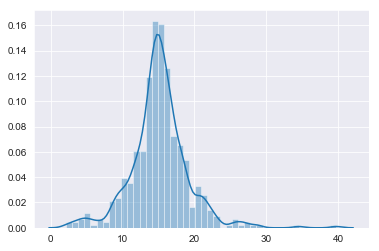

In [4]:
import numpy as np
import seaborn as sns

np.random.seed(444)
np.set_printoptions(precision=3)
d = np.random.laplace(loc=15, scale=3, size=500)
d[:10]

sns.set_style('darkgrid')
sns.distplot(d)